 ![](https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/se_03b.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/SE03_CA_Physics_informed_neural_networks.ipynb)
# Workshop Instructions
***
- <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> Follow along by typing the code yourself - this helps with learning!
- <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> Code cells marked as "Exercise" are for you to complete
- <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> Look for hints if you get stuck
- <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/success.svg" width="20" /> Compare your solution with the provided answers
- <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/list.svg" width="20" /> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
# Download utils from GitHub
!wget -q --show-progress https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/colab_utils.txt -O colab_utils.txt
!wget -q --show-progress -x -nH --cut-dirs=3 -i colab_utils.txt

colab_utils.txt     100%[===================>]   1.57K  --.-KB/s    in 0s      
utils/__init__.py   100%[===================>]   1.75K  --.-KB/s    in 0s      
utils/__version__.p 100%[===================>]     234  --.-KB/s    in 0s      
utils/core.py       100%[===================>]  55.36K  --.-KB/s    in 0.007s  
utils/quizzes.json  100%[===================>]  18.63K  --.-KB/s    in 0s      
utils/solutions.jso 100%[===================>]  45.93K  --.-KB/s    in 0.002s  
utils/data/__init__ 100%[===================>]     766  --.-KB/s    in 0s      
utils/data/datasets 100%[===================>]   8.36K  --.-KB/s    in 0s      
utils/data/download 100%[===================>]  11.24K  --.-KB/s    in 0s      
utils/data/uwmgi.py 100%[===================>]  11.78K  --.-KB/s    in 0s      
utils/ml/__init__.p 100%[===================>]     526  --.-KB/s    in 0s      
utils/ml/metrics.py 100%[===================>]   3.60K  --.-KB/s    in 0s      
utils/ml/scaling.py 100%[===============

In [2]:
from pathlib import Path
import sys

repo_path = Path.cwd()
if str(repo_path) not in sys.path:
    sys.path.append(str(repo_path))

import utils
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import inspect

print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Please ensure you've enabled GPU in Runtime > Change runtime type")

checker = utils.core.ExerciseChecker("SE03P")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.1.0+4edc6ee
GPU available: True
GPU device: Tesla T4


# 1. Introduction to PINNs
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: Physics-Informed Neural Networks (PINNs) are neural networks that are trained to solve supervised learning tasks while respecting physical laws described by partial differential equations.

Physics-Informed Neural Networks (PINNs) are a class of deep learning models that integrate physical laws, typically expressed as partial differential equations (PDEs), directly into the learning process. Instead of relying solely on data, PINNs leverage known physics to constrain the model, allowing for more robust learning, especially in scenarios where data is scarce or noisy.

PINNs combine two major concepts:

| Component | Description | Role |
|-----------|-------------|------|
| **Neural Networks** | Deep learning models that can approximate complex functions | Learn patterns from data |
| **Physical Laws** | Mathematical equations describing system behavior | Enforce physical constraints |

## 1.1 Why PINNs?
***
Traditional numerical methods for solving PDEs face several challenges:

| Challenge | Traditional Methods | PINN Solution |
|-----------|---------------------|---------------|
| **Computational Cost** | High for complex geometries | Efficient once trained |
| **Mesh Requirements** | Need fine meshes | Meshless approach |
| **Limited Data** | Require complete boundary conditions | Can work with sparse data |
| **High Dimensions** | Suffer from curse of dimensionality | Better scaling with dimensions |
| **Generalisation** | Limited to specific problems | Generalises to new conditions |


# 2. Case Study: Navier-Stokes Equations
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: The Navier-Stokes equations are partial differential equations that describe the motion of viscous fluid substances, forming the basis of fluid dynamics.

These equations govern the motion of incompressible fluids in 2D:

**Momentum equations:**
$$
\begin{aligned}
\frac{\partial u}{\partial t} + \lambda_1 (u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}) &= -\frac{\partial p}{\partial x} + \lambda_2 (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) \quad \text{(momentum in x-direction)} \\
\frac{\partial v}{\partial t} + \lambda_1 (u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}) &= -\frac{\partial p}{\partial y} + \lambda_2 (\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}) \quad \text{(momentum in y-direction)}
\end{aligned}
$$

**Continuity equation (incompressibility condition):**
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

**Meaning of terms:**
- $u(x, y, t)$: horizontal velocity
- $v(x, y, t)$: vertical velocity
- $p(x, y, t)$: pressure
- $\lambda_1$: convection coefficient (usually 1)
- $\lambda_2 = \nu $: kinematic viscosity

These equations state that:
- Fluids accelerate due to pressure differences and internal friction (viscosity)
- Mass is conserved → the flow remains incompressible



## 2.1 Flow past a cylinder
***
In this notebook we are going to explore a realistic scenario of incompressible fluid flow as described by the ubiquitous Navier-Stokes equations. Navier-Stokes equations describe the physics of many phenomena of scientific and engineering. Often, the Navier-Stokes equations are solved using numerical methods, such as finite element or finite volume methods. However, these methods can be computationally expensive and time-consuming, especially for complex geometries and boundary conditions.
In this workshop, we will use a dataset of incompressible fluid flow around a cylinder. The dataset is generated using a finite volume method and contains the velocity and pressure fields of the fluid flow. The dataset consists of the following variables:

| Variable | Description |
|----------|-------------|
| u        | x-component of velocity |
| v        | y-component of velocity |
| p        | pressure |
| t        | time |

The dataset was prepared using the following simulation parameters:
- **Domain**: \( [-15, 25] \times [-8, 8] \)
- **Reynolds number**: \( Re = 100 \)
- **Numerical method**: Spectral/hp-element solver (NekTar)
- **Mesh**: 412 triangular elements, 10th-order basis functions
- **Integration**: Third-order stiff scheme until steady vortex shedding


For this problem, we want to predict the Convective term $\lambda_1$, the viscous term $\lambda_2$, as well as a reconstruction of the pressure field $p$.

In [3]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('cylinder',
                                   dest_path=data_path,
                                   extract=False,
                                   remove_compressed=False)


Downloading:
Cylinder dataset for predicting the drag coefficient of a cylinder in a flow field
> Authors: Maziar Raissi1, Paris Perdikaris, George Em Karniadakis
> Year: 2017
> Website: https://arxiv.org/pdf/1711.10566.pdf



In [4]:
data = scipy.io.loadmat(dataset_path)
u_star = data['U_star'] # velocity n x 2 x time
p_star = data['p_star'] # pressure n x time
x_star = data['X_star'] # coordinates n x 2
time = data['t'] # time n x 1

print(f'We have {u_star.shape[0]} points in space, {u_star.shape[1]} dimensions and {u_star.shape[2]} time steps.')

We have 5000 points in space, 2 dimensions and 200 time steps.


In [5]:
utils.plotting.wake_cylinder_interactive(x_star, u_star, p_star, time, figsize=(12, 6))

interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

Output()

# 3. Preparing the dataset
***
As you can see in the image above, the simulation has been cropped to a smaller domain that does not include the cylinder. Thus, with this dataset we are only using 1% of the total data for training. This is to highlight the ability of PINNs to learn from limited data. In practice, you would typically use a larger portion of the dataset for training. Thus, we are not going to split the dataset into training, validation, and test sets. Instead, we will use the entire dataset for training and testing. This is a common practice in PINNs, where the model is trained on a small portion of the data and then tested on the entire dataset.

The training data consists of the following parameters:
- Region: Small rectangle downstream of cylinder
- Sampled: \( u(x, y, t), v(x, y, t) \)
- Size: 5,000 points (\~1% of simulation)
- **No pressure data used**

To prepare the data we need to load the dataset and extract the relevant variables. Furthermore, we need to reshape the data to be compatible with the PINN model.

## 3.1 Normalisation
***
For PINNs, the features cannot be normalised in the same way as in traditional machine learning. Standard normalization in PINNs is tricky because physical equations must remain consistent with the scaled variables. The normalisation should be applied to the loss function considering the physics of the problem. This is a more complex process and requires a deeper understanding of the physical equations involved.

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/list.svg" width="20" /> In this workshop, we will not cover this topic in detail, but it is important to keep in mind that normalisation in PINNs is not as straightforward as in traditional machine learning.

In [6]:
# Exercise 6: Prepare the data for training 🎯
# Implement:
# 1. Create a meshgrid-like structure for the x, y, and t coordinates
# 2. Flatten the velocity and pressure data into NT x 1 arrays
# 3. Randomly sample N points from the flattened data
# 4. Convert the sampled data into PyTorch tensors

N, T = x_star.shape[0], time.shape[0] # number of points in space and time

# Create coordinate grids
x_flat = x_star[:, 0]  # Extract x coordinates
y_flat = x_star[:, 1]  # Extract y coordinates
t_flat = time.flatten() # Flatten time array

# Create meshgrid-like structures for visualization
x_coords = np.tile(x_flat[:, np.newaxis], (1, T))  # Repeat x for each timestep
y_coords = np.tile(y_flat[:, np.newaxis], (1, T))  # Repeat y for each timestep
time_coords = np.tile(t_flat, (N, 1))              # Repeat time for each spatial point

# Extract velocity and pressure data
u_vals = u_star[:, 0, :]  # Extract u velocity
v_vals = u_star[:, 1, :]  # Extract v velocity
p_vals = p_star[:, :]     # Extract pressure

# Flatten into NT x 1 arrays
x = x_coords.flatten()[:, np.newaxis]
y = y_coords.flatten()[:, np.newaxis]
t = time_coords.flatten()[:, np.newaxis]
u = u_vals.flatten()[:, np.newaxis]
v = v_vals.flatten()[:, np.newaxis]
p = p_vals.flatten()[:, np.newaxis]

idx = np.random.choice(N*T, N, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

# Preparing the data as tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

t_train = torch.tensor(t_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
v_train = torch.tensor(v_train, dtype=torch.float32)

# ✅ Check your answer
answer = {
    'x_train': x_train,
    'y_train': y_train,
    't_train': t_train,
    'u_train': u_train,
    'v_train': v_train,
    'data_shape': x_train.shape[0]
}
checker.check_exercise(6, answer)

--------------------------------------------------------------------------------
✅ x_train is correct!
✅ y_train is correct!
✅ t_train is correct!
✅ u_train is correct!
✅ v_train is correct!
✅ data_shape is correct!

🎉 Excellent! All parts are correct!


# 4. PINN Architecture
***
In this workshop we are going to use a Physics-Informed Neural Network (PINN) to solve the Navier-Stokes equations. The PINN model is a neural network that is trained to satisfy the Navier-Stokes equations, as well as the boundary conditions of the problem. The PINN model consists of the following components:

| Component | Purpose | Implementation |
|-----------|---------|----------------|
| **Input Layer** | Takes spatial/temporal coordinates | $(x, y, t)$ coordinates |
| **Hidden Layers** | Learn the underlying patterns | Multiple fully connected layers |
| **Output Layer** | Predicts physical quantities | Velocity and pressure fields |
| **Physics Loss** | Enforces PDE constraints | Automatic differentiation |

***

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/pinn.png" width="80%">
</div>


For the connected layers we are going to use the following activation functions:

| Layer | Activation Function |
|-------|---------------------|
| Input Layer | Tanh |
| Hidden Layers | Tanh |
| Output Layer | Tanh |

The choice of activation function for the output layer is important, as it can affect the range of the output values. In this case, we are using Tanh to ensure that the output values are in the range [-1, 1]. This is important for the PINN model, as we want to ensure that the predicted values are in the same range as the input features.

In [7]:
# Exercise 7: Model Creation with Weight Initialization 🎯
# Implement:
# 1. Define a class for the Navier-Stokes PINN model
# 2. Initialize the model with a specified number of hidden layers and neurons
# 3. Use Xavier initialization for the weights and biases of each layer
# 4. Define the forward pass to compute the velocity and pressure outputs
# 5. Split the output into u, v, and p components

class NavierStokesPINN(torch.nn.Module):
    def __init__(self, hidden_size=20, num_layers=9):
        super().__init__()
        self.nu = 0.01  # kinematic viscosity

        # Neural network architecture
        layers = []
        # Input layer: x, y, t
        input_layer = torch.nn.Linear(3, hidden_size)
        torch.nn.init.xavier_normal_(input_layer.weight)
        torch.nn.init.zeros_(input_layer.bias)

        layers.append(input_layer)


        # Hidden layers
        for _ in range(num_layers - 1):
            hidden_layer = torch.nn.Linear(hidden_size, hidden_size)
            torch.nn.init.xavier_normal_(hidden_layer.weight)
            torch.nn.init.zeros_(hidden_layer.bias)

            layers.append(hidden_layer)

        # Output layer:  u,v,p because we are enforcing the continuity equation
        output_layer = torch.nn.Linear(hidden_size, 3)
        torch.nn.init.xavier_normal_(output_layer.weight)
        torch.nn.init.zeros_(output_layer.bias)
        layers.append(output_layer)

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x, y, t):
        # Combine inputs
        xyz = torch.cat([x, y, t], dim=1)

        # Forward pass through network
        for i in range(len(self.net)-1):
            xyz = torch.tanh(self.net[i](xyz))

        # Final layer without activation
        output = self.net[-1](xyz)

        # Split output into u, v, p
        u = output[:, 0:1]
        v = output[:, 1:2]
        p = output[:, 2:3]

        return u, v, p

model = NavierStokesPINN(hidden_size=20, num_layers=9)

# ✅ Check your answer
answer = {
    'model': model,
    'hidden_size': model.net[0].out_features,
    'input_size': model.net[0].in_features,
    'output_size': model.net[-1].out_features,
    'num_layers': len(model.net)
}
checker.check_exercise(7, answer)

--------------------------------------------------------------------------------
✅ model is correct!
✅ hidden_size is correct!
✅ input_size is correct!
✅ output_size is correct!
✅ num_layers is correct!

🎉 Excellent! All parts are correct!



# 5. PINN Loss Function
***
When working with PINNs, the loss function is a crucial component that combines data loss and physics loss. The data loss measures how well the model fits the training data, while the physics loss measures how well the model satisfies the physical constraints defined by the PDEs. Thus, the loss function is defined as follows:

$$
\text{Loss} = \text{Data Loss} + \text{Physics Loss}$$

$$\text{Data Loss} = \frac{1}{N} \sum_{i=1}^{N} (u_i - u_{\text{pred}, i})^2 + (v_i - v_{\text{pred}, i})^2$$
$$\text{Physics Loss} = \frac{1}{M} \sum_{j=1}^{M} (f_{u,j}^2 + f_{v,j}^2 + f_{c,j}^2)$$

Where:
- $f_u = \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$
- $f_v = \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)$
- $f_c = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}$
- $f_c$: Continuity equation (incompressibility condition)
- $f_u$: Momentum equation in x-direction
- $f_v$: Momentum equation in y-direction
- $N$: Number of data points in the training set
- $M$: Number of points in the physics loss (collocation points)

The physics loss ensures that the solution satisfies the Navier-Stokes equations, while the data loss ensures the solution matches known data points. This dual optimization approach is what makes PINNs powerful for solving PDEs.

## 5.1 Automatic Differentiation in PINNs
***
One of the key features of PINNs is their ability to automatically compute derivatives using automatic differentiation (autograd). This is crucial for enforcing physical constraints defined by PDEs.

### 5.1.1 How Automatic Differentiation Works
When we use `torch.autograd.grad()`, PyTorch computes derivatives through the computational graph:

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 1**: Basic usage of `torch.autograd.grad()`

```python
u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
```

The `torch.autograd.grad()` function returns a tuple of gradients. The first element is the gradient of `u` with respect to `t`.

| Parameter | Purpose | Description |
|-----------|---------|-------------|
| `u` | Target tensor | The output we want to differentiate |
| `t` | Source tensor | The variable we're differentiating with respect to |
| `grad_outputs` | Scaling factor | Usually ones, for direct gradient computation |
| `create_graph` | Enable higher derivatives | Needed for second derivatives |


In [8]:
# Exercise 8: Compute Residuals 🎯
# Implement:
# 1. Define a function to compute the residuals of the Navier-Stokes equations
# 2. Enable gradients for the input variables (x, y, t)
# 3. Compute the first and second derivatives of the velocity and pressure fields
# 4. Calculate the residuals for the u and v momentum equations and the continuity equation
# 5. Return the residuals as outputs

#Function to compute the derivatives for the physics loss
def compute_ns_residuals(model, x, y, t):
    # Enable gradients
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    # Get predictions
    u, v, p = model(x, y, t)

    # First derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    # Compute residuals
    f_u = u_t + (u * u_x + v * u_y) + p_x - model.nu * (u_xx + u_yy)
    f_v = v_t + (u * v_x + v * v_y) + p_y - model.nu * (v_xx + v_yy)
    f_c = u_x + v_y  # continuity equation

    return f_u, f_v, f_c


In [9]:
# Create a small test case to verify the residual calculation
test_x = torch.ones((5, 1), requires_grad=True)
test_y = torch.ones((5, 1), requires_grad=True)
test_t = torch.ones((5, 1), requires_grad=True)

test_fu, test_fv, test_fc = compute_ns_residuals(model, test_x, test_y, test_t)

# ✅ Check your answer
answer = {
    'f_u_shape': test_fu.shape,
    'f_v_shape': test_fv.shape,
    'f_c_shape': test_fc.shape,
    'has_gradients': test_fu.requires_grad
}
checker.check_exercise(8, answer)

--------------------------------------------------------------------------------
✅ f_u_shape is correct!
✅ f_v_shape is correct!
✅ f_c_shape is correct!
✅ has_gradients is correct!

🎉 Excellent! All parts are correct!


# 6. PINN Optimiser and training
***
When training a PINN model, the choice of optimiser is crucial for achieving good performance. A common practice is to use a two-step approach:

1. Use a standard optimiser (like Adam) to train the model, often called the "warm-up" phase.
2. Switch to a more advanced optimiser (like L-BFGS) for fine-tuning.

This approach allows for faster convergence in the initial phase and better performance in the final phase.

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: The use of only Adam or L-BFGS is also possible, however, without the fine-tuning step the model will have an issue finding the right scale of the loss function. Resulting in a model that creates good qualitative results, but poor quantitative results.

The warm-up phase follows the standard training process, where the model is trained using a standard optimiser (like Adam) for a certain number of epochs. The fine-tuning phase uses a more advanced optimiser (like L-BFGS) to refine the model parameters and improve performance.

To use the L-BFGS optimiser, we need to define a closure function that computes the loss and gradients. The closure function is called by the optimiser to compute the loss and gradients, and it should return the loss value. The closure function should also zero out the gradients before computing the loss, as shown in the code snippet below.

***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using L-BFGS Optimiser

```python
import torch.optim as optim

# Define the model
model = PINNModel()
# Define the loss function
loss_function = PINNLoss()
# Define the optimizer
optimizer = optim.LBFGS(model.parameters(),
                                    lr=0.1,
                                    max_iter=500,
                                    max_eval=500,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-8,
                                    history_size=50,
                                    line_search_fn="strong_wolfe")
# Define the closure function
def closure():
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    return loss

# Training loop
for epoch in range(num_epochs):
    optimizer.step(closure)
```


In [10]:
# Exercise 9: The training loop 🎯
# Implement:
# 1. Define a training function for the PINN model
# 2. Use Adam optimizer for the first phase of training
# 3. Use L-BFGS optimizer for the second phase of training
# 4. Compute the loss as a combination of data loss and physics loss
# 5. Use a closure function to compute the loss and gradients for L-BFGS

def train_pinn(model, data, epochs=10000, use_lbfgs=True):
    count = 0
    bLBFGS = False
    x, y, t, u_true, v_true = data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Move data to device
    x = x.to(device)
    y = y.to(device)
    t = t.to(device)
    u_true = u_true.to(device)
    v_true = v_true.to(device)

    # Adam optimization first
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()

    losses = {
        'data_loss': [],
        'physics_loss': [],
        'total_loss': [],
        'lbfgs_data_loss': [],
        'lbfgs_physics_loss': [],
        'lbfgs_total_loss': []
    }


    def closure():
        nonlocal count
        optimizer.zero_grad()

        # Data loss
        u_pred, v_pred, _ = model(x, y, t)
        data_loss = mse_loss(u_pred, u_true) + mse_loss(v_pred, v_true)

        # Physics loss
        f_u, f_v, f_c = compute_ns_residuals(model, x, y, t)
        physics_loss = (torch.mean(f_u**2) + torch.mean(f_v**2) +
                       torch.mean(f_c**2))

        # Total loss
        loss = data_loss + physics_loss
        loss.backward()

        if bLBFGS:
            losses['lbfgs_data_loss'].append(data_loss.item())
            losses['lbfgs_physics_loss'].append(physics_loss.item())
            losses['lbfgs_total_loss'].append(loss.item())

            print('\r' + f"Training with LBFGS at epoch {count}: data Loss: {data_loss.item()}, "
                  f"physics Loss: {physics_loss.item()}, "
                  f"total Loss: {loss.item()}", end='')
            count += 1
        else:
            losses['data_loss'].append(data_loss.item())
            losses['physics_loss'].append(physics_loss.item())
            losses['total_loss'].append(loss.item())

        return loss

    # Train with Adam
    pbar = tqdm(range(epochs), desc="Training with Adam")
    for _ in pbar:
        loss = closure()
        optimizer.step()

        pbar.set_postfix({
            'data_loss': losses['data_loss'][-1],
            'physics_loss': losses['physics_loss'][-1],
            'total_loss': losses['total_loss'][-1]
        })


    # L-BFGS optimization
    if use_lbfgs:
        bLBFGS = True
        optimizer = torch.optim.LBFGS(model.parameters(),
                                    max_iter=500,
                                    max_eval=500,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-8,
                                    history_size=50,
                                    line_search_fn="strong_wolfe")

        optimizer.step(closure)

    return model, losses

# Test with a smaller number of epochs
test_model = NavierStokesPINN(hidden_size=20, num_layers=9)
data_tuple = (x_train[:10], y_train[:10], t_train[:10], u_train[:10], v_train[:10])

test_trained_model, losses = train_pinn(test_model,
                                        data_tuple,
                                        epochs=2,
                                        use_lbfgs=False)


Training with Adam: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s, data_loss=0.401, physics_loss=0.0341, total_loss=0.435]


In [11]:
# ✅ Check your answer
# Analyze the training function to extract important components
train_fn_code = inspect.getsource(train_pinn)

# Check for key components in the code
has_adam = 'Adam' in train_fn_code
has_lbfgs = 'LBFGS' in train_fn_code
has_closure = 'def closure' in train_fn_code
has_data_loss = 'data_loss' in train_fn_code
has_physics_loss = 'physics_loss' in train_fn_code
computes_residuals = 'compute_ns_residuals' in train_fn_code
updates_weights = 'optimizer.step()' in train_fn_code
backprop = 'backward()' in train_fn_code

answer = {
    'function_code': train_fn_code,  # For deeper inspection
    'has_adam': has_adam,
    'has_lbfgs': has_lbfgs,
    'uses_closure': has_closure,
    'has_data_loss': has_data_loss,
    'has_physics_loss': has_physics_loss,
    'computes_residuals': computes_residuals,
    'updates_weights': updates_weights,
    'uses_backpropagation': backprop,
    'learning_rate': 0.001 if 'lr=0.001' in train_fn_code else None,
    'optimizer_params': {
        'has_max_iter': 'max_iter=' in train_fn_code,
        'has_line_search': 'line_search_fn=' in train_fn_code
    }
}
checker.check_exercise(9, answer)

--------------------------------------------------------------------------------
✅ function_code is correct!
✅ has_adam is correct!
✅ has_lbfgs is correct!
✅ uses_closure is correct!
✅ has_data_loss is correct!
✅ has_physics_loss is correct!
✅ computes_residuals is correct!
✅ updates_weights is correct!
✅ uses_backpropagation is correct!
✅ learning_rate is correct!
✅ optimizer_params is correct!

🎉 Excellent! All parts are correct!


In [12]:
# Run the training loop with the full dataset
# Initialize model
model = NavierStokesPINN(hidden_size=20, num_layers=9)

# Train model
trained_model, losses = train_pinn(
    model,
    (x_train, y_train, t_train, u_train, v_train),
    epochs=10000,
    use_lbfgs=True
)

# save the model
torch.save(trained_model.state_dict(), 'se03_pinn_model.pth')

Training with Adam: 100%|██████████| 10000/10000 [08:03<00:00, 20.68it/s, data_loss=0.00325, physics_loss=0.00188, total_loss=0.00513]


Training with LBFGS at epoch 499: data Loss: 0.002233306411653757, physics Loss: 0.0016501579666510224, total Loss: 0.0038834642618894577

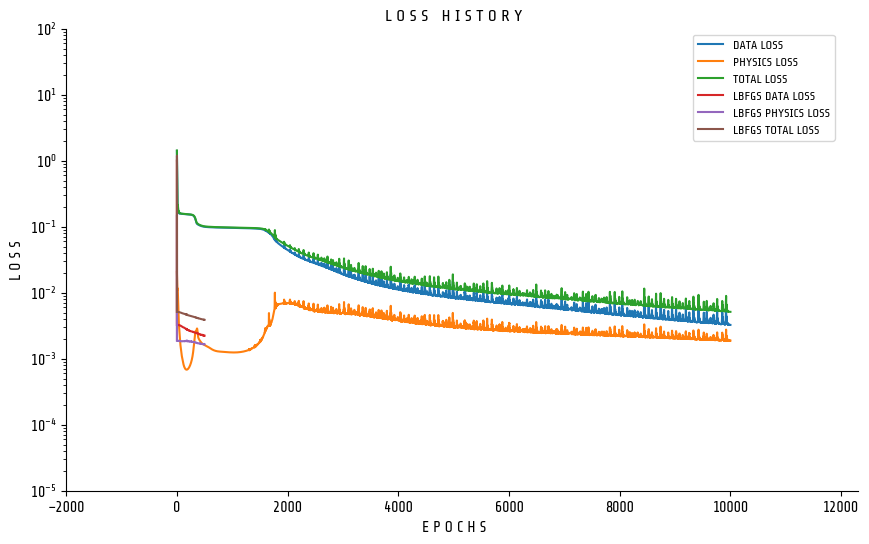

In [13]:
# Visualize the loss history
def plot_loss_history(losses):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(losses['data_loss'], label='Data Loss',)
    ax.plot(losses['physics_loss'], label='Physics Loss')
    ax.plot(losses['total_loss'], label='Total Loss')
    ax.plot(losses['lbfgs_data_loss'], label='LBFGS Data Loss')
    ax.plot(losses['lbfgs_physics_loss'], label='LBFGS Physics Loss')
    ax.plot(losses['lbfgs_total_loss'], label='LBFGS Total Loss')
    ax.set_yscale('log')

    utils.plotting.make_fig_pretty(ax, title='Loss History', xlabel='Epochs', ylabel='Loss')


plot_loss_history(losses)

## 6.1 Evaluation

Unlike standard models where performance is often quantified with scalar metrics like Mean Squared Error (MSE) or R-squared, PINNs are typically evaluated by comparing predicted and true physical fields over time (e.g., velocity and pressure fields in fluid dynamics).

Here, we generate predictions from the trained model across all time steps and compare them to the ground truth values. Since we're modeling time-dependent flow behavior, we loop over each time snapshot and feed spatial coordinates (x, y) along with the corresponding time value t into the model. We compute and collect the predicted fields:

- `u_pred`: Predicted horizontal velocity

- `v_pred`: Predicted vertical velocity

- `p_pred`: Predicted pressure

These are then compared against the ground truth data from the test set for visual inspection and potential error metrics like relative L2 norm or RMSE (if applicable).

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: When passing the data to the model, we need to ensure the tensors have `requires_grad=True`. This is important for the autograd engine to track operations on these tensors and compute gradients correctly. This is especially crucial when using optimisers like L-BFGS, which rely on gradient information to update model parameters.

In [14]:
# Exercise 10: Inference and Visualization 🎯
# Implement:
# 1. Load the trained model
# 2. Set the model to evaluation mode
# 3. Move the model to CPU for inference
# 4. Create input tensors with requires_grad=True
# 5. Get predictions for u, v, and p
# 6. Store predictions in lists and convert to arrays
# 7. Reshape ground truth data

# Load the trained model
model = NavierStokesPINN(hidden_size=20, num_layers=9)
model.load_state_dict(torch.load('se03_pinn_model.pth'))

model.eval()
model.to('cpu') # Move model to CPU for inference
with torch.no_grad():
    u_pred = []
    v_pred = []
    p_pred = []

    for t_idx in range(time.shape[0]):
        # Create input tensors with requires_grad=True
        x_tensor = torch.FloatTensor(x_star[:,0]).view(-1, 1).requires_grad_(True)
        y_tensor = torch.FloatTensor(x_star[:,1]).view(-1, 1).requires_grad_(True)
        t_tensor = torch.full_like(x_tensor, time[t_idx,0]).requires_grad_(True)

        # Get predictions - temporarily enable gradients
        with torch.enable_grad():
            u_t, v_t, p_t = model(x_tensor, y_tensor, t_tensor)

        # Store predictions
        u_pred.append(u_t.detach().cpu().numpy())
        v_pred.append(v_t.detach().cpu().numpy())
        p_pred.append(p_t.detach().cpu().numpy())

    # Convert to arrays and reshape
    u_pred = np.stack(u_pred, axis=1)  # Shape: (N, T)
    v_pred = np.stack(v_pred, axis=1)  # Shape: (N, T)
    p_pred = np.stack(p_pred, axis=1)  # Shape: (N, T)

In [15]:
# Reshape ground truth data
u_true = u_star[:, 0, :]  # Shape: (N, T)
v_true = u_star[:, 1, :]  # Shape: (N, T)
p_true = p_star  # Shape: (N, T)

# ✅ Check your answer
answer = {
    'u_pred_shape': u_pred.shape,
    'v_pred_shape': v_pred.shape,
    'p_pred_shape': p_pred.shape,
    'requires_grad_used': True
}
checker.check_exercise(10, answer)

# Create visualization
utils.plotting.visualize_flow_comparison_interactive(
    x_star, u_true, v_true, p_true,
    u_pred, v_pred, p_pred, time,
    figsize=(18, 4),
)

--------------------------------------------------------------------------------
✅ u_pred_shape is correct!
✅ v_pred_shape is correct!
✅ p_pred_shape is correct!
✅ requires_grad_used is correct!

🎉 Excellent! All parts are correct!


interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

Output()